# Restricted Boltzmann Machines

## Imports and Helper Functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
import pickle
import sys
from matplotlib.animation import FuncAnimation
import train_imgs
import time as t

In [2]:
def corrupt_img(img, k, return_flat=False):
    img = img.flatten()
    rands = np.random.permutation(img.shape[0])[:k]
    img[rands] = img[rands]*-1
    if return_flat: return img
    return img.reshape(10, 10)

def list_to_bin(a):
    to_return = ""
    for num in a:
        if num == 1:
            to_return += "1"
        else:
            to_return += "0"
    return to_return

def bin_to_list(a):
    if "b" in a:
        a = a[2:]
    to_return = []
    for i in range(len(a)):
        if a[i] == "1":
            to_return.append(1)
        else:
            to_return.append(-1)
    return np.array(to_return)

def list_to_int(a):
    return int(list_to_bin(a), 2)

def int_to_list(a, n):
    return bin_to_list(f'{a:{n}b}')

## RBM Class

In [126]:
class RBM():
    
    def __init__(self, Nv, Nh, training=0, weights=0, a=0, b=0, v=0, h=0):
        self.Nv = Nv
        self.Nh = Nh
        if not training == 0:
            self.training = training
        if type(v)==int:
            self.v = np.random.choice([-1, 1], size=Nv)
        if type(h)==int:
            self.h = np.random.choice([-1, 1], size=Nh)
        if type(weights)==int:
            self.w = 2*np.random.rand(Nv, Nh) - 1
        if type(a)==int:
            self.a = 2*np.random.rand(Nv) - 1
        if type(b)==int:
            self.b = 2*np.random.rand(Nh) - 1
        self.trained_dist = None
    
    def calc_energy(self):
        return -(self.v.T @ self.w @ self.h + self.v.T @ self.a + self.h.T @ self.b) 
    
    def sample_hidden(self, num=1):
        to_return = []
        for i in range(num):
            mh = self.w.T @ self.v + self.b
#             ps = np.exp(mh)/(np.exp(mh)+np.exp(-mh))
            ps = 0.5 * (1 + np.tanh(mh))  # Sigmoid function using tanh
            to_return.append(np.array([2*int(res)-1 for res in ps > np.random.rand(ps.shape[0])]))
        if num == 1:
            return to_return[0]
        return np.array(to_return)
    
    def sample_visible(self, num=1):
        to_return = []
        for i in range(num):
            mv = self.w @ self.h + self.a
#             ps = np.exp(mv)/(np.exp(mv)+np.exp(-mv))
            ps = 0.5 * (1 + np.tanh(mv))  # Sigmoid function using tanh
            to_return.append(np.array([2*int(res)-1 for res in ps > np.random.rand(ps.shape[0])]))
        if num==1:
            return to_return[0]
        return np.array(to_return)


    
    def gibbs(self, k=10, n=100000, together=False):
        h_samples = []
        v_samples = []
        for i in range(n):
            for j in range(k):
                self.h = self.sample_hidden()
                self.v = self.sample_visible()
            h_samples.append(np.copy(self.h))
            v_samples.append(np.copy(self.v))
        if together:
            return np.concatenate((np.array(v_samples), np.array(h_samples)), axis=1)
        return np.array(v_samples), np.array(h_samples)
    
    def get_state(self):
        return np.concatenate((self.v, self.h))
    
    def set_visible(self, v):
        self.v = v
        return
    
    def set_hidden(self, h):
        self.h = h
        return
    
    def train(self, dist=0, M=64, k=1, eta=0.1, epochs=30, batch_per_epoch=1500):
        if type(dist) == int:
            dist = np.random.ranf(2**self.Nv)
            dist = dist/np.sum(dist)
        if dist.shape[0] != 2**self.Nv:
            print(f"Dist Vector Size = {dist.shape[0]}")
        for i in range(epochs):
            samples = np.random.choice(range(2**self.Nv),p=dist,size=M*batch_per_epoch)
            batch = 0
            for j in range(batch_per_epoch):
                dw = np.zeros(shape=self.w.shape)
                da = np.zeros(shape=self.a.shape)
                db = np.zeros(shape=self.b.shape)
                for sample in samples[batch*64:(batch+1)*64]:
                    self.v = np.array(int_to_list(sample, self.Nv))
                    self.h = self.sample_hidden()
                    dw -= np.outer(self.v, self.h)
                    da -= self.v
                    db -= self.h
                    for i in range(k):
                        self.h = self.sample_hidden()
                        self.v = self.sample_visible()
                    dw += np.outer(self.v, self.h)
                    da += self.v
                    db += self.h
                self.w += (eta/M)*dw
                self.a += (eta/M)*da
                self.b += (eta/M)*db
                batch += 1
        self.trained_dist = dist
        return dist
    
    def train_GPT(self, data, epochs, lr, k, M):
        num_data = len(data)
        num_batches = num_data // M

        for epoch in range(epochs):
            np.random.shuffle(data)
            for batch_idx in range(num_batches):
                batch_data = data[batch_idx * M:(batch_idx + 1) * M]

                dW, da, db = np.zeros((self.Nv, self.Nh)), np.zeros(self.Nv), np.zeros(self.Nh)

                for v in batch_data:
                    # Positive phase
                    self.set_visible(v)
                    mh0 = self.w.T @ self.v + self.b
                    ph0 = 0.5 * (1 + np.tanh(mh0))

                    # Negative phase (Gibbs sampling)
                    for _ in range(k):
                        nv = self.sample_visible(num=1)
                        self.set_visible(nv)
                        nh = self.sample_hidden(num=1)
                        self.set_hidden(nh)

                    mhk = self.w.T @ self.v + self.b
                    phk = 0.5 * (1 + np.tanh(mhk))


                    # Accumulate gradients
                    dW += np.outer(v, ph0.ravel()) - np.outer(nv.ravel(), phk.ravel())
                    da += v - nv.ravel()
                    db += ph0.ravel() - phk.ravel()

                # Update weights and biases
                self.w += lr * dW / M
                self.a += lr * da / M
                self.b += lr * db / M

            # Print the progress
            print(f"Epoch {epoch + 1}/{epochs} completed.")
            
    def plot_vs_dist(self, n=100000, dist=0):
        if type(dist) == int: dist = self.trained_dist
        visible_samples, _ = self.gibbs(n=n)
        fake_samples = np.random.choice(range(2**self.Nv),p=dist,size=1000000)
        visible_samples = [list_to_int(a) for a in visible_samples]
        hist = np.histogram(visible_samples, bins=int(2**self.Nv), range=(0, 2**self.Nv), density=True)

        plt.figure()
        plt.plot(dist)
        plt.bar(hist[1][:-1], hist[0], width=0.7, label="Measured", color='r')
#         plt.hist(visible_samples,density=True,bins=2**self.Nv)
        plt.show()
        

## Testing RBM

Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


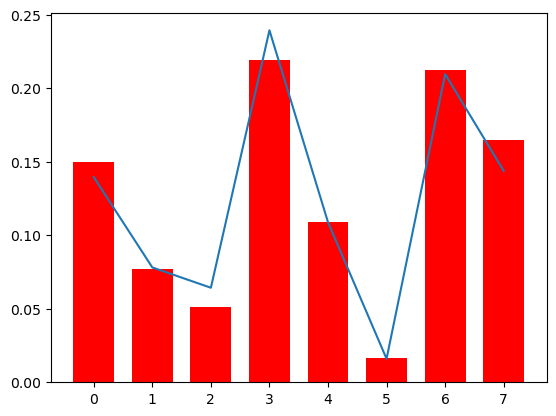

In [127]:
# Generate random target distribution
dist = np.random.ranf(2**3)
dist = dist / np.sum(dist)

# Generate training samples based on the target distribution
samples = np.random.choice(range(2**3), p=dist, size=100000)

# Convert integers to binary vectors
samples_binary = np.array([[(1 if digit=='1' else -1) for digit in format(num, f'0{3}b')] for num in samples])

# Initialize the RBM with Glorot-initialized weights
testing = RBM(Nv=3, Nh=8)

# Train the RBM using the train_GPT function
testing.train_GPT(samples_binary, epochs=10, lr=0.1, k=1, M=64)

# Plot the learned distribution vs the target distribution
testing.plot_vs_dist(n=10000, dist=dist)

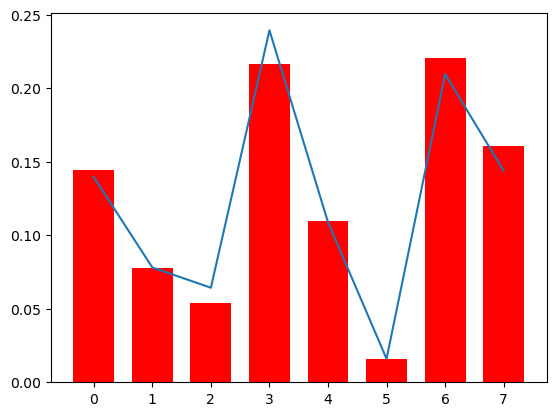

In [128]:
testing.plot_vs_dist(n=100000, dist=dist)

[0.04961428 0.03666005 0.02787299 0.01941913 0.04088032 0.03445706
 0.03571517 0.04694657 0.02863941 0.01015068 0.01092474 0.04159778
 0.03542059 0.03254721 0.04830833 0.03013752 0.04664405 0.03265751
 0.04413005 0.04156265 0.03598125 0.0278164  0.03123434 0.02083715
 0.01636004 0.02003588 0.05267644 0.03223362 0.01809798 0.01340529
 0.021208   0.01582756]


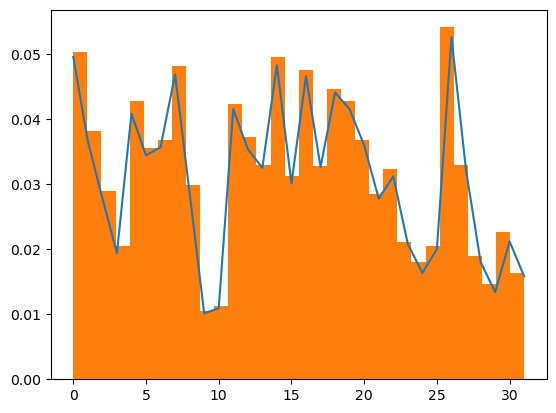

In [6]:
prob_dist=np.random.ranf(32)
prob_dist=prob_dist/np.sum(prob_dist)
samples=np.random.choice(range(0,32),p=prob_dist,size=100000)
print(prob_dist)
### Below just for plotting the distribution you got
plt.plot(prob_dist)
plt.hist(samples,density=True,bins=32)
plt.show()

## Grading

### Gibbs Sampling

In [4]:
## Theory Probability Functions
def theory_h_given_v(Nv, Nh, v, w, b):
    probs = []
    for i in range(int(2**Nh)):
        h = int_to_list(i, Nh)
        m = w.T @ v + b
        prob = np.prod(np.exp(m*h)/(np.exp(m*h)+np.exp(-m*h)))
        probs.append([i, prob])
    return probs

def theory_v_given_h(Nv, Nh, h, w, a):
    probs = []
    for i in range(int(2**Nv)):
        v = int_to_list(i, Nv)
        m = w @ h + a
        prob = np.prod(np.exp(m*v)/(np.exp(m*v)+np.exp(-m*v)))
        probs.append([i, prob])
    return probs

def theory_v(Nv, Nh, w, a, b):
    probs = []
    states = []
    v_groups = []
    vs = []
    for i in range(int(2**Nv)):
        v = int_to_list(i, Nv)
        vs.append(v)
        v_group = []
        for j in range(int(2**Nh)):
            h = int_to_list(j, Nh)
            states.append([v, h])
            v_group.append([v, h])
        v_groups.append(v_group)
    Es = np.array([-(v.T @ w @ h + v.T @ a + h.T @ b) for [v, h] in states])
    Ps = np.exp(-Es)
    Z = np.sum(Ps)
    for i in range(len(v_groups)):
        group = v_groups[i]
        this_v = vs[i]
        top = np.exp(-np.array([-(v.T @ w @ h + v.T @ a + h.T @ b) for [v, h] in group]))
        summation = np.sum(top)
        probs.append([list_to_int(this_v), summation/Z])
    return probs
            
def theory_h(Nv, Nh, w, a, b):
    probs = []
    states = []
    h_groups = []
    hs = []
    for i in range(int(2**Nh)):
        h = int_to_list(i, Nh)
        hs.append(h)
        h_group = []
        for j in range(int(2**Nv)):
            v = int_to_list(j, Nv)
            states.append([v, h])
            h_group.append([v, h])
        h_groups.append(h_group)
    Es = np.array([-(v.T @ w @ h + v.T @ a + h.T @ b) for [v, h] in states])
    Ps = np.exp(-Es)
    Z = np.sum(Ps)
    for i in range(len(h_groups)):
        group = h_groups[i]
        this_h = hs[i]
        top = np.exp(-np.array([-(v.T @ w @ h + v.T @ a + h.T @ b) for [v, h] in group]))
        summation = np.sum(top)
        probs.append([list_to_int(this_h), summation/Z])
    return probs

def theory_v_h(Nv, Nh, w, a, b, together=False):
    states = []
    pre_probs = []
    for i in range(int(2**Nh)):
        h = int_to_list(i, Nh)
        for j in range(int(2**Nv)):
            v = int_to_list(j, Nv)
            pre_prob = np.exp(v.T @ w @ h + v.T @ a + h.T @ b)
            pre_probs.append([v, h, pre_prob])
            states.append([v, h])
    Es = np.array([-(v.T @ w @ h + v.T @ a + h.T @ b) for [v, h] in states])
    Ps = np.exp(-Es)
    Z = np.sum(Ps)
    if together:
        return [(list_to_int(np.concatenate((np.array(v), np.array(h)), axis=0)), pre_prob/Z) for [v, h, pre_prob] in pre_probs]
    return [(list_to_int(a), list_to_int(b), pre_prob/Z) for [a, b, pre_prob] in pre_probs]

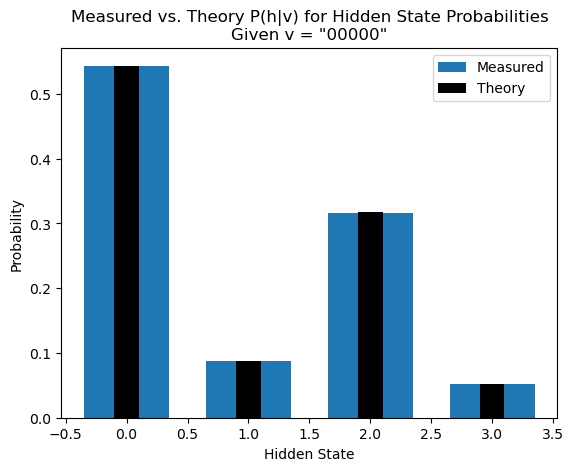

Maximum Difference Between Measured and Theory Probabilities: 0.0009528044548519632


In [6]:
Nv = 5
Nh = 2
testing = RBM(Nv, Nh)
v = np.array([0, 0, 0, 0, 0])
num = 100000
testing.set_visible(v)
results = testing.sample_hidden(num)
theory = theory_h_given_v(Nv, Nh, v, testing.w, testing.b)
plt.figure()
results = [int(list_to_bin(a), 2) for a in results]
hist = np.histogram(results, bins=int(2**Nh), range=(0, 2**Nh), density=True)
plt.bar(hist[1][:-1], hist[0], width=0.7, label="Measured")
plt.bar([a[0] for a in theory], [a[1] for a in theory],
        width=0.2, color='black', label="Theory")
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Hidden State")
plt.title("Measured vs. Theory P(h|v) for Hidden State Probabilities\nGiven v = \"00000\"")
plt.show()

probs_theory = np.array([a[1] for a in theory])
probs_measured = np.array(hist[0])
differences = probs_theory-probs_measured
print(f"Maximum Difference Between Measured and Theory Probabilities: {np.max(differences)}")

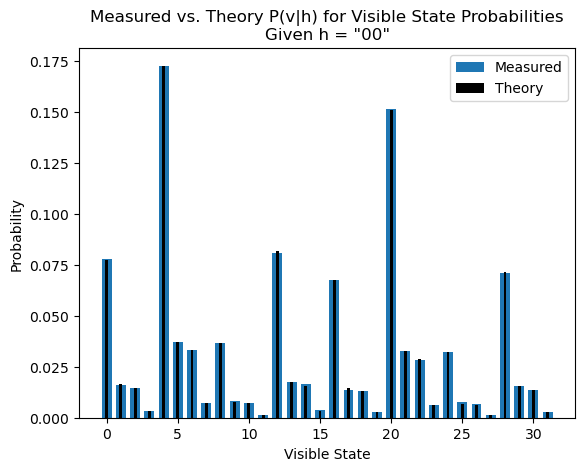

Maximum Difference Between Measured and Theory Probabilities: 0.0009469339637321553


In [7]:
Nv = 5
Nh = 2
testing = RBM(Nv, Nh)
h = np.array([0, 0])
num = 100000
testing.set_hidden(h)
results = testing.sample_visible(num)
theory = theory_v_given_h(Nv, Nh, h, testing.w, testing.a)
plt.figure()
results = [int(list_to_bin(a), 2) for a in results]
hist = np.histogram(results, bins=int(2**Nv), range=(0, 2**Nv), density=True)
plt.bar(hist[1][:-1], hist[0], width=0.7, label="Measured")
plt.bar([a[0] for a in theory], [a[1] for a in theory],
        width=0.2, color='black', label="Theory")
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Visible State")
plt.title("Measured vs. Theory P(v|h) for Visible State Probabilities\nGiven h = \"00\"")
plt.show()

probs_theory = np.array([a[1] for a in theory])
probs_measured = np.array(hist[0])
differences = probs_theory-probs_measured
print(f"Maximum Difference Between Measured and Theory Probabilities: {np.max(differences)}")

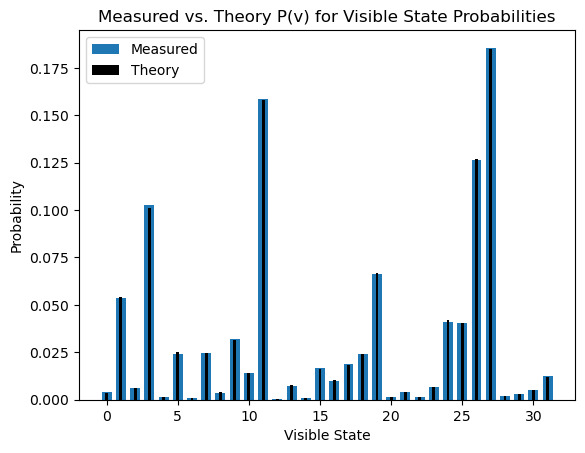

Maximum Difference Between Measured and Theory Probabilities: 0.001054706452165377


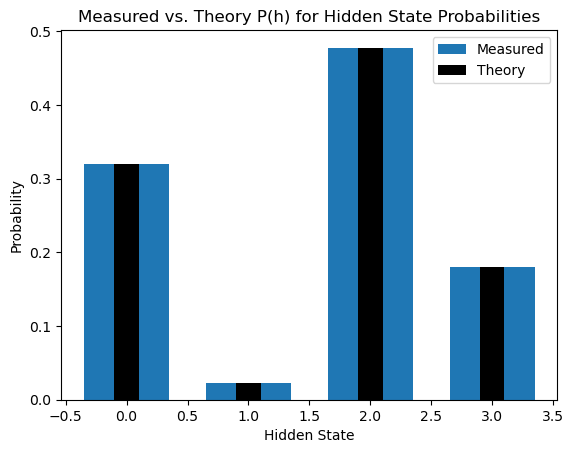

Maximum Difference Between Measured and Theory Probabilities: 0.000843367402300399


In [10]:
with open("Gibbs_samples_h.pkl", "rb") as fp:   # Unpickling
    h_results = pickle.load(fp)
with open("Gibbs_samples_v.pkl", "rb") as fp:   # Unpickling
    v_results = pickle.load(fp)
with open("Gibbs_theory_h.pkl", "rb") as fp:   # Unpickling
    h_theory = pickle.load(fp)
with open("Gibbs_theory_v.pkl", "rb") as fp:   # Unpickling
    v_theory = pickle.load(fp)
    
Nv = 5
Nh = 2
# testing = RBM(Nv, Nh)
num = 100000
# v_results, h_results = testing.gibbs(k=10, n=num)
# v_theory = theory_v(Nv, Nh, testing.w, testing.a, testing.b)
# h_theory = theory_h(Nv, Nh, testing.w, testing.a, testing.b)

plt.figure()
# v_results = [int(list_to_bin(a), 2) for a in v_results]
v_hist = np.histogram(v_results, bins=int(2**Nv), range=(0, 2**Nv), density=True)
plt.bar(v_hist[1][:-1], v_hist[0], width=0.7, label="Measured")
plt.bar([a[0] for a in v_theory], [a[1] for a in v_theory],
        width=0.2, color='black', label="Theory")
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Visible State")
plt.title("Measured vs. Theory P(v) for Visible State Probabilities")
plt.show()

probs_theory = np.array([a[1] for a in v_theory])
probs_measured = np.array(v_hist[0])
differences = probs_theory-probs_measured
print(f"Maximum Difference Between Measured and Theory Probabilities: {np.max(differences)}")

plt.figure()
# h_results = [int(list_to_bin(a), 2) for a in h_results]
h_hist = np.histogram(h_results, bins=int(2**Nh), range=(0, 2**Nh), density=True)
plt.bar(h_hist[1][:-1], h_hist[0], width=0.7, label="Measured")
plt.bar([a[0] for a in h_theory], [a[1] for a in h_theory],
        width=0.2, color='black', label="Theory")
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Hidden State")
plt.title("Measured vs. Theory P(h) for Hidden State Probabilities")
plt.show()

probs_theory = np.array([a[1] for a in h_theory])
probs_measured = np.array(h_hist[0])
differences = probs_theory-probs_measured
print(f"Maximum Difference Between Measured and Theory Probabilities: {np.max(differences)}")

# with open("Gibbs_samples_h.pkl", "wb") as fp:   #Pickling
#     pickle.dump(h_results, fp)
# with open("Gibbs_samples_v.pkl", "wb") as fp:   #Pickling
#     pickle.dump(v_results, fp)
# with open("Gibbs_theory_h.pkl", "wb") as fp:   #Pickling
#     pickle.dump(h_theory, fp)
# with open("Gibbs_theory_v.pkl", "wb") as fp:   #Pickling
#     pickle.dump(v_theory, fp)

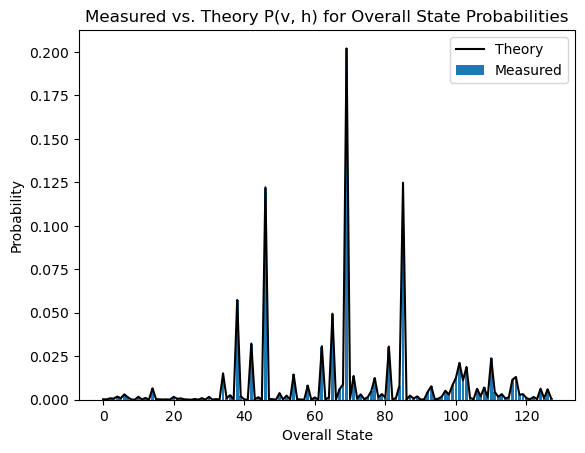

Maximum Difference Between Measured and Theory Probabilities: 0.0002725409517481264


In [10]:
with open("Gibbs_hist.pkl", "rb") as fp:   # Unpickling
    hist = pickle.load(fp)
with open("Gibbs_theory.pkl", "rb") as fp:   # Unpickling
    theory = pickle.load(fp)

Nv = 5
Nh = 2
testing = RBM(Nv, Nh)
num = 1000000
# results = np.array([list_to_int(a) for a in testing.gibbs(k=10, n=num, together=True)])
# hist = np.histogram(results, bins=int(2**(Nv+Nh)), range=(0, 2**(Nv+Nh)), density=True)
# theory = np.sort(np.array(theory_v_h(Nv, Nh, testing.w, testing.a, testing.b, together=True), dtype=[('state', int), ('prob', float)]))

plt.figure()
plt.bar(hist[1][:-1], hist[0], label="Measured")
plt.plot([a[0] for a in theory], [a[1] for a in theory], color='black', label="Theory")
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Overall State")
plt.title("Measured vs. Theory P(v, h) for Overall State Probabilities")
plt.show()

probs_theory = np.array([a[1] for a in theory])
probs_measured = np.array(hist[0])
differences = probs_theory-probs_measured
print(f"Maximum Difference Between Measured and Theory Probabilities: {np.max(differences)}")

# with open("Gibbs_hist.pkl", "wb") as fp:   #Pickling
#     pickle.dump(hist, fp)
# with open("Gibbs_theory.pkl", "wb") as fp:   #Pickling
#     pickle.dump(theory, fp)